In [1]:
from importlib import reload
import sys
import actorcritic as ac
import environment as gw
import memory as ec

sys.modules['gw'] = gw
sys.modules['ac'] = ac
# TODO -- need to do this for all imported modules????

import run_experiment as expt

import pickle
import pandas as pd
import uuid
from analysis import DataFilter
## remove after july 24
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from environment import plotting as gp

In [2]:
reload(expt)
reload(ec)
experiment_type = 5
env_type     = None
rho          = 0.0
arch         = 'B'
rwd_mag      = 10
use_pvals    = False
#mem_temp     = 1
mem_envelope = 50
alpha        = 1
beta         = 100000
RECORD       = True

for mem_temp in [1]:
    parent_dir = './data/'
    log_file = 'sep2020.csv'

    # set environment parameters
    rows, columns = 20, 20
    penalty = -0.01
    if experiment_type == 0:
        reward_location = (5, 5)
    else:
        reward_location = (15, 15)


    # generate environment object
    env = gw.GridWorld(rows=rows, cols=columns, env_type=env_type,
                       rewards={reward_location: rwd_mag},
                       step_penalization=penalty,
                       rho=rho,
                       actionlist=['Down', 'Up', 'Right', 'Left'],
                       rewarded_action=None)

    # agent parameters
    training = {
        'load_model': False,
        'load_dir': '',

        'architecture': arch,
        'input_dims': env.observation.shape,
        'action_dims': len(env.action_list),
        'hidden_types': ['conv', 'pool', 'conv', 'pool', 'linear', 'linear'],
        'hidden_dims': [None, None, None, None, 100, 200],

        'freeze_w': False,

        'rfsize': 5,

        'gamma': 0.98,
        'eta': 5e-4,

        'use_EC': False
    }

    testing_1 = training.copy()
    testing_1.update({'load_model': True, 'freeze_w': True})

    testing_2 = testing_1.copy()
    testing_2.update({'use_EC': True})

    testing_4 = testing_1.copy()
    testing_4.update({'freeze_w': False})

    testing_5 = testing_4.copy()
    testing_5.update({'use_EC': True})

    params = [training, testing_1, testing_2, testing_2, testing_4, testing_5, testing_5]

    NUM_TRIALS = 5000
    NUM_EVENTS = 250

    # mixing parameters for MF-EC control
    # alpha = 0.01 # MF confidence boost for reward
    # beta = 100 # MF confidence decay - number of steps to decay to 1%

    # create an agent with parameters for a given experiment type
    agent_params = params[experiment_type]
    load_id = ' '
    if experiment_type != 0:
        # read csv file - get id tag for matching conditions
        df = pd.read_csv(parent_dir + log_file)
        filter = DataFilter(df,
                            expt_type=[0],
                            env_type=[str(env_type)],
                            dims=[str(env.shape)],
                            rho=[float(env.rho)],
                            rewards=[f'{{(5, 5): {rwd_mag}}}'],
                            arch=[arch])

        load_id = list(filter.ids)[0]
        agent_params['load_dir'] = parent_dir + f'agent_weights/{load_id}.pt'
        print(f'loading weights from {load_id}')
        #env_id = 'b3d8e1c3-0ff6-48e9-831e-9164773b78a0'
        #env = pickle.load(open(parent_dir + f'environments/{env_id}_env.p', 'rb'))

        env = pickle.load(open(parent_dir + f'environments/{load_id}_env.p', 'rb'))
        rwd_ = float(filter.info.iloc[0]['rewards'].strip('{}').split(':')[1])
        # set new reward location and update env.R accordingly 
        env.step_penalization = penalty
        env.rewards = {reward_location: rwd_}
        env.buildRewardFunction()
        env.finish_after_first_reward = True

    agent = ac.make_agent(agent_params)

    if experiment_type in [2, 3, 5, 6]:
        # create memory module
        mem = ec.EpisodicMemory(cache_limit=400,
                                entry_size=agent.action_dims,
                                mem_temp=mem_temp,
                                mem_envelope=mem_envelope,
                                pvals=use_pvals)
    else:
        mem = None
    # create run_id
    run_id = uuid.uuid4()
    # create experiment object
    ex = expt.Experiment(agent, env, use_mem=agent_params['use_EC'], mem=mem)

    # run experiment
    ex.run(NUM_TRIALS, NUM_EVENTS, alpha=alpha, beta=beta, get_samples=True, printfreq=1)

    # log data
    if RECORD:
        expt.data_log(log_file, run_id, experiment_type, ex, append_data=False, load_from=load_id)

    if experiment_type == 10:#!= 0:
        #### trying some craziness -- delete later (Jul 24)
        plt.figure(0)
        x = ex.data['confidence_selection'][0] # MFCS
        y = ex.data['confidence_selection'][1] # policy_choice
        viridis = cm.get_cmap('inferno', len(x)).colors
        plt.scatter(x, y, c = viridis, alpha=0.3)
        plt.yticks([0,1], ['MF', 'EC'])
        plt.ylim([-0.5, 1.5])
        plt.show()
        plt.close()


        plt.figure(1)
        y = ex.data['confidence_selection'][0] # MFCS
        x = np.arange(len(x))
        cols = ['b', 'g'] #mf , ec
        z = ex.data['confidence_selection'][1] # policy_choice
        col = [cols[i] for i in z]
        plt.scatter(x, y, c = col, alpha=0.3)
        plt.ylim([0,1])
        plt.ylabel('MF Confidence Score')
        plt.show()
        plt.close()



loading weights from 016375f6-eb4f-46b5-8ce1-80a6ad0ad603
0: -2.4999999999999907 (0.5515773296356201s / Running Av: -2.4999999999999907
1: -2.4999999999999907 (7.448649644851685s / Running Av: -1.6666666666666605
2: -2.4999999999999907 (1.8739078044891357s / Running Av: -1.458333333333328
3: 9.26 (1.016430377960205s / Running Av: 0.9770000000000032
4: 9.82 (0.35369300842285156s / Running Av: 2.288000000000002
5: -2.4999999999999907 (2.9136900901794434s / Running Av: 1.2771428571428598
6: -2.4999999999999907 (2.9961957931518555s / Running Av: 0.6453571428571461
7: -2.4999999999999907 (3.2350778579711914s / Running Av: 0.22416666666667018
8: -2.4999999999999907 (3.8782434463500977s / Running Av: -0.07066666666666292
9: -2.4999999999999907 (3.0279340744018555s / Running Av: -0.2850909090909052
10: 7.959999999999999 (2.4581942558288574s / Running Av: 0.42575757575757894
11: -2.4999999999999907 (3.1225528717041016s / Running Av: 0.16794871794872135
12: -2.4999999999999907 (2.966791629791259

124: 9.86 (0.2728159427642822s / Running Av: 4.6385999999999985
125: 9.69 (0.4859447479248047s / Running Av: 4.6418503937007864
126: -2.4999999999999907 (3.0193891525268555s / Running Av: 4.549790231299212
127: 9.77 (0.4836556911468506s / Running Av: 4.554987281976743
128: 9.86 (0.36194300651550293s / Running Av: 4.56075670840787
129: 9.299999999999999 (1.0203347206115723s / Running Av: 4.562119201409276
130: 9.75 (0.4664762020111084s / Running Av: 4.566859819569742
131: 9.98 (0.22555327415466309s / Running Av: 4.573222829801775
132: 9.87 (0.27092909812927246s / Running Av: 4.578622489058465
133: 9.8 (0.36408352851867676s / Running Av: 4.583383637368709
134: 9.81 (0.41294193267822266s / Running Av: 4.588113289760345
135: 8.349999999999998 (2.0321521759033203s / Running Av: 4.582082438814939
136: 9.88 (0.39321160316467285s / Running Av: 4.587269649846606
137: 9.86 (0.29782962799072266s / Running Av: 4.592201021791259
138: 9.79 (0.4878861904144287s / Running Av: 4.596526721479955
139: 9.

252: -2.4999999999999907 (3.1998112201690674s / Running Av: 4.6923909931219
253: 9.85 (0.4029512405395508s / Running Av: 4.694215377489571
254: 9.75 (0.4650387763977051s / Running Av: 4.695627757352933
255: 9.43 (0.8206863403320312s / Running Av: 4.695778514105051
256: 9.72 (0.5281007289886475s / Running Av: 4.69705154887943
257: 9.74 (0.4982423782348633s / Running Av: 4.698387058154492
258: 9.83 (0.4466969966888428s / Running Av: 4.700053311553304
259: 9.86 (0.3274357318878174s / Running Av: 4.701815355142933
260: 9.87 (0.3379218578338623s / Running Av: 4.703595390599856
261: 9.85 (0.35669589042663574s / Running Av: 4.7052790758424425
262: 9.99 (0.20764636993408203s / Running Av: 4.707473931328485
263: 9.84 (0.444260835647583s / Running Av: 4.709077901658081
264: 9.9 (0.3136100769042969s / Running Av: 4.710889346006517
265: 9.88 (0.33554911613464355s / Running Av: 4.712605530680626
266: 9.73 (0.48842382431030273s / Running Av: 4.713742802839725
267: 9.9 (0.2882232666015625s / Running 

379: 9.91 (0.22840118408203125s / Running Av: 4.51861624533775
380: 9.84 (0.38814854621887207s / Running Av: 4.520717730964254
381: -2.4999999999999907 (3.2174599170684814s / Running Av: 4.49058343471901
382: -2.4999999999999907 (3.2637627124786377s / Running Av: 4.4606845626631815
383: 9.85 (0.35312676429748535s / Running Av: 4.463096590909086
384: 9.78 (0.39139747619628906s / Running Av: 4.465308525671215
385: 9.91 (0.22233986854553223s / Running Av: 4.467839230964904
386: 9.78 (0.5435104370117188s / Running Av: 4.470015317403229
387: 9.9 (0.3712155818939209s / Running Av: 4.472483104974421
388: 9.69 (0.519146203994751s / Running Av: 4.474393448025834
389: 9.81 (0.48760271072387695s / Running Av: 4.476596039084526
390: 9.89 (0.3047935962677002s / Running Av: 4.478985855211646
391: 9.87 (0.2834649085998535s / Running Av: 4.4813065378823245
392: 9.87 (0.35652613639831543s / Running Av: 4.4836095503803834
393: 9.91 (0.23362421989440918s / Running Av: 4.485996337467065
394: 9.99 (0.12768

507: 9.9 (0.3110349178314209s / Running Av: 4.53041357919651
508: 9.72 (0.5673675537109375s / Running Av: 4.531706074964366
509: 9.87 (0.2894632816314697s / Running Av: 4.533284524768811
510: 9.9 (0.3155069351196289s / Running Av: 4.534912319593933
511: 9.9 (0.30291247367858887s / Running Av: 4.536530595151072
512: 9.64 (0.6649453639984131s / Running Av: 4.537633588944258
513: 9.81 (0.4358828067779541s / Running Av: 4.539060254618261
514: 9.86 (0.34815001487731934s / Running Av: 4.540575524949198
515: 9.87 (0.29750776290893555s / Running Av: 4.542101344968738
516: 9.67 (0.5209946632385254s / Running Av: 4.543232227806697
517: 9.85 (0.42898130416870117s / Running Av: 4.544703394558886
518: 9.96 (0.15996098518371582s / Running Av: 4.546377612272122
519: 9.64 (0.5826113224029541s / Running Av: 4.547427986121365
520: 9.86 (0.27808570861816406s / Running Av: 4.548893779277988
521: 9.72 (0.4881556034088135s / Running Av: 4.550083478018799
522: 9.709999999999999 (0.539435625076294s / Running 

636: 9.92 (0.2720193862915039s / Running Av: 4.6120321058252065
637: 9.39 (0.8284192085266113s / Running Av: 4.612291786245159
638: 9.86 (0.36830639839172363s / Running Av: 4.613284624413143
639: 9.94 (0.20135498046875s / Running Av: 4.614397620904834
640: 9.9 (0.3863086700439453s / Running Av: 4.615443111182389
641: 9.87 (0.37413954734802246s / Running Av: 4.616437067290686
642: 9.85 (0.3823230266571045s / Running Av: 4.617395337268044
643: 8.76 (1.7248196601867676s / Running Av: 4.61665922769512
644: 9.87 (0.36575913429260254s / Running Av: 4.617644802841574
645: 9.83 (0.46387553215026855s / Running Av: 4.618563984285649
646: 9.88 (0.3371908664703369s / Running Av: 4.619556070753903
647: 9.79 (0.4359772205352783s / Running Av: 4.620404896421841
648: 9.85 (0.43561267852783203s / Running Av: 4.621342112125158
649: 9.89 (0.25795960426330566s / Running Av: 4.622336452794513
650: 9.82 (0.34805798530578613s / Running Av: 4.623218856313548
651: 10.0 (0.1388871669769287s / Running Av: 4.6243

765: 9.77 (0.5684792995452881s / Running Av: 4.662022085981456
766: 9.85 (0.3715939521789551s / Running Av: 4.662706924299212
767: 9.87 (0.6561484336853027s / Running Av: 4.663415098748369
768: 9.7 (0.5825557708740234s / Running Av: 4.663899734855516
769: 9.94 (0.25532054901123047s / Running Av: 4.664693769265748
770: 9.86 (0.416628360748291s / Running Av: 4.665381091107029
771: 9.84 (0.3929426670074463s / Running Av: 4.666039872242586
772: 9.9 (0.26113009452819824s / Running Av: 4.6667736193427345
773: 9.88 (0.4981961250305176s / Running Av: 4.667478719679915
774: 9.88 (0.36445045471191406s / Running Av: 4.66818109411373
775: 9.84 (0.38005733489990234s / Running Av: 4.668829276625663
776: 9.84 (0.47501134872436523s / Running Av: 4.669474959719171
777: 9.83 (0.5055620670318604s / Running Av: 4.670105319257761
778: 9.87 (0.32294535636901855s / Running Av: 4.6707845363878695
779: 9.87 (0.5221648216247559s / Running Av: 4.671461144489309
780: 9.82 (0.6580526828765869s / Running Av: 4.6720

895: 9.75 (0.455242395401001s / Running Av: 4.731820789038867
896: -2.4999999999999907 (3.360516309738159s / Running Av: 4.718498248306042
897: 9.7 (0.5440418720245361s / Running Av: 4.718790799477775
898: 9.77 (0.4977281093597412s / Running Av: 4.719160153256714
899: 9.87 (0.36057281494140625s / Running Av: 4.71963926501419
900: 9.88 (0.31479835510253906s / Running Av: 4.720127869748084
901: 9.76 (0.4810609817504883s / Running Av: 4.720481960844988
902: 9.97 (0.20722627639770508s / Running Av: 4.721067177745773
903: 9.94 (0.18438243865966797s / Running Av: 4.721617305529761
904: 9.48 (0.7773370742797852s / Running Av: 4.721657885429253
905: 9.709999999999999 (0.5573644638061523s / Running Av: 4.721951914347821
906: 9.87 (0.35222434997558594s / Running Av: 4.722421183258949
907: 9.79 (0.4564990997314453s / Running Av: 4.722800894626916
908: 9.92 (0.20957207679748535s / Running Av: 4.723322211342022
909: 9.86 (0.3042600154876709s / Running Av: 4.723775949626671
910: 9.79 (0.469729423522

1022: -2.4999999999999907 (3.5348472595214844s / Running Av: 4.6574030310667185
1023: -2.4999999999999907 (3.165465831756592s / Running Av: 4.645876391006101
1024: 9.99 (0.22561120986938477s / Running Av: 4.646556943850143
1025: -2.4999999999999907 (3.228562355041504s / Running Av: 4.635073872878673
1026: -2.4999999999999907 (3.232811212539673s / Running Av: 4.623624312814707
1027: -2.4999999999999907 (3.488170623779297s / Running Av: 4.612208133392326
1028: -2.4999999999999907 (3.391075849533081s / Running Av: 4.600825204977973
1029: -2.4999999999999907 (3.2394185066223145s / Running Av: 4.589475398566765
1030: -2.4999999999999907 (3.8160576820373535s / Running Av: 4.578158585778844
1031: -2.4999999999999907 (3.2742044925689697s / Running Av: 4.566874638855749
1032: 9.16 (1.3681056499481201s / Running Av: 4.566900026401482
1033: -2.4999999999999907 (4.242264032363892s / Running Av: 4.555659639877035
1034: -2.4999999999999907 (3.406737804412842s / Running Av: 4.544451802734415
1035: -2

1133: -2.4999999999999907 (3.3462183475494385s / Running Av: 3.9696584931900722
1134: 8.549999999999999 (2.019726037979126s / Running Av: 3.970196066265442
1135: 9.65 (0.6436371803283691s / Running Av: 3.971699679165591
1136: -2.4999999999999907 (3.810666799545288s / Running Av: 3.9625227025765475
1137: 9.81 (0.5632367134094238s / Running Av: 3.9641776232041575
1138: 9.94 (0.3483765125274658s / Running Av: 3.9659422238652025
1139: 9.0 (2.78251576423645s / Running Av: 3.966878346172187
1140: 9.74 (0.6406478881835938s / Running Av: 3.968459995303234
1141: 9.89 (0.5191459655761719s / Running Av: 3.970168726720026
1142: -2.4999999999999907 (4.612796068191528s / Running Av: 3.961042557617369
1143: 9.69 (0.602928638458252s / Running Av: 3.9625865880844127
1144: 9.059999999999999 (1.4809913635253906s / Running Av: 3.963576838366988
1145: -2.4999999999999907 (3.3241050243377686s / Running Av: 3.954486033069051
1146: 9.33 (1.1735589504241943s / Running Av: 3.9557238622797324
1147: 9.92 (0.39705

1254: 9.8 (0.4288961887359619s / Running Av: 3.946014286801836
1255: 9.94 (0.1878800392150879s / Running Av: 3.9476435401243464
1256: 9.83 (0.343961238861084s / Running Av: 3.9491814677235126
1257: 9.94 (0.191880464553833s / Running Av: 3.950803101611164
1258: 9.84 (0.3234095573425293s / Running Av: 3.9523415093863843
1259: 9.95 (0.2359914779663086s / Running Av: 3.953963489545962
1260: 9.84 (0.32345128059387207s / Running Av: 3.955494450735271
1261: 9.77 (0.4055142402648926s / Running Av: 3.956966351842579
1262: 9.92 (0.2699246406555176s / Running Av: 3.9585534303997907
1263: 9.89 (0.3306722640991211s / Running Av: 3.960113029719317
1264: 9.86 (0.35720372200012207s / Running Av: 3.961645236623393
1265: 9.91 (0.28752899169921875s / Running Av: 3.9632132788702386
1266: 9.98 (0.13715386390686035s / Running Av: 3.9648328162852695
1267: -2.4999999999999907 (3.276285171508789s / Running Av: 3.956614009640218
1268: 9.83 (0.43387627601623535s / Running Av: 3.958123278916375
1269: 9.85 (0.3040

1380: 9.95 (0.23830533027648926s / Running Av: 4.07344088314535
1381: 9.93 (0.22625517845153809s / Running Av: 4.074730194955697
1382: 9.8 (0.6292831897735596s / Running Av: 4.075922781379171
1383: 9.77 (0.587306022644043s / Running Av: 4.077091123933137
1384: 9.86 (0.5187258720397949s / Running Av: 4.07832187267205
1385: 9.85 (0.5444695949554443s / Running Av: 4.079542749567981
1386: 9.8 (0.6634764671325684s / Running Av: 4.080724964626241
1387: 9.92 (0.39453816413879395s / Running Av: 4.081991019392798
1388: 9.84 (0.7021594047546387s / Running Av: 4.083196787710218
1389: 9.74 (0.9050438404083252s / Running Av: 4.084328064794747
1390: 9.79 (0.546605110168457s / Running Av: 4.08549282332234
1391: 9.89 (0.4772815704345703s / Running Av: 4.08672686090551
1392: 9.92 (0.2503662109375s / Running Av: 4.087979763544096
1393: 9.92 (0.27399730682373047s / Running Av: 4.089229971768406
1394: 9.86 (0.42684388160705566s / Running Av: 4.09043451335613
1395: 9.76 (0.5573368072509766s / Running Av: 4

1506: 9.96 (0.3108797073364258s / Running Av: 4.157315956130454
1507: 9.89 (0.33048582077026367s / Running Av: 4.1583599376332625
1508: 9.91 (0.2847144603729248s / Running Av: 4.1594150900337485
1509: 9.75 (0.5223357677459717s / Running Av: 4.160362257353359
1510: 9.89 (0.3219289779663086s / Running Av: 4.161400137965326
1511: 10.0 (0.13698506355285645s / Running Av: 4.162508663890025
1512: 9.549999999999999 (0.7716913223266602s / Running Av: 4.1633177673723365
1513: 9.89 (0.3316521644592285s / Running Av: 4.164349691111779
1514: 9.7 (0.6069152355194092s / Running Av: 4.16525424297047
1515: 9.56 (0.7478616237640381s / Running Av: 4.166064718589494
1516: 9.86 (0.37558746337890625s / Running Av: 4.167071220936544
1517: 9.56 (0.6990432739257812s / Running Av: 4.167878237103842
1518: 9.9 (0.3712465763092041s / Running Av: 4.1689073446866
1519: 9.95 (0.1946566104888916s / Running Av: 4.16996729558116
1520: 9.52 (0.9223494529724121s / Running Av: 4.1707426342203435
1521: 9.92 (0.269449234008

1627: -2.4999999999999907 (3.1657345294952393s / Running Av: 4.080951862208772
1628: -2.4999999999999907 (3.250905990600586s / Running Av: 4.074410816979068
1629: 8.93 (1.6904103755950928s / Running Av: 4.07488977367192
1630: -2.4999999999999907 (3.2184901237487793s / Running Av: 4.068364173459087
1631: -2.4999999999999907 (3.2162251472473145s / Running Av: 4.061850561489143
1632: 8.969999999999999 (1.4456005096435547s / Running Av: 4.062368492258434
1633: -2.4999999999999907 (3.1783244609832764s / Running Av: 4.055870182176161
1634: -2.4999999999999907 (3.533952474594116s / Running Av: 4.04938378831042
1635: -2.4999999999999907 (3.2685980796813965s / Running Av: 4.042909281544006
1636: 8.87 (1.5827105045318604s / Running Av: 4.043388024789984
1637: -2.4999999999999907 (3.1733319759368896s / Running Av: 4.036928734948873
1638: -2.4999999999999907 (3.278245449066162s / Running Av: 4.030481260881862
1639: 9.28 (1.1869516372680664s / Running Av: 4.03122412345239
1640: -2.4999999999999907 

1745: 9.72 (0.618990421295166s / Running Av: 3.94243620711926
1746: -2.4999999999999907 (5.318042516708374s / Running Av: 3.9364952045939514
1747: 8.969999999999999 (1.668339490890503s / Running Av: 3.9371224256292927
1748: -2.4999999999999907 (3.3421120643615723s / Running Av: 3.931194285714288
1749: 9.64 (0.6793646812438965s / Running Av: 3.932209483560417
1750: 9.74 (0.4698326587677002s / Running Av: 3.93328002067964
1751: 9.66 (0.6171107292175293s / Running Av: 3.934303089680576
1752: 9.549999999999999 (0.7825527191162109s / Running Av: 3.935261695051522
1753: -2.4999999999999907 (3.474071502685547s / Running Av: 3.9293525649147107
1754: 8.78 (1.9276046752929688s / Running Av: 3.9298772203077466
1755: 9.54 (0.7849490642547607s / Running Av: 3.930833535367157
1756: 9.74 (0.475874662399292s / Running Av: 3.931901984132382
1757: 9.84 (0.5067148208618164s / Running Av: 3.933025461125978
1758: -2.4999999999999907 (3.723626136779785s / Running Av: 3.9271356594656077
1759: 9.86 (0.3791534

1864: -2.4999999999999907 (3.236355781555176s / Running Av: 3.8742781709668477
1865: 8.94 (1.5672223567962646s / Running Av: 3.8749163303980563
1866: 8.409999999999998 (2.308846950531006s / Running Av: 3.875269739037887
1867: -2.4999999999999907 (3.854285955429077s / Running Av: 3.8697852342342083
1868: -2.4999999999999907 (3.6727278232574463s / Running Av: 3.8643095281013373
1869: 8.899999999999999 (1.5794503688812256s / Running Av: 3.864935600225227
1870: 9.03 (1.4792289733886719s / Running Av: 3.8656301134728492
1871: -2.4999999999999907 (3.4495339393615723s / Running Av: 3.860167614686439
1872: -2.4999999999999907 (3.2647292613983154s / Running Av: 3.8547138605619073
1873: -2.4999999999999907 (3.2974605560302734s / Running Av: 3.8492688324439746
1874: -2.4999999999999907 (3.5008931159973145s / Running Av: 3.8438325117270833
1875: 9.95 (0.3331010341644287s / Running Av: 3.845037804735365
1876: -2.4999999999999907 (3.9498958587646484s / Running Av: 3.8396117793842093
1877: -2.4999999

1974: -2.4999999999999907 (3.7719004154205322s / Running Av: 3.550627056321433
1975: -2.4999999999999907 (3.979340076446533s / Running Av: 3.545770579784942
1976: 8.299999999999999 (2.5087456703186035s / Running Av: 3.5463815296537136
1977: 9.709999999999999 (0.6662931442260742s / Running Av: 3.5477040344241493
1978: -2.4999999999999907 (3.901021957397461s / Running Av: 3.5428578687328116
1979: 9.76 (0.5022163391113281s / Running Av: 3.544207835548831
1980: -2.4999999999999907 (3.710920810699463s / Running Av: 3.5393700879852097
1981: 8.469999999999999 (2.32678484916687s / Running Av: 3.5400716814416042
1982: -2.4999999999999907 (3.6935296058654785s / Running Av: 3.5352429801498286
1983: 9.87 (0.39199113845825195s / Running Av: 3.5366533146786447
1984: 9.86 (0.28432464599609375s / Running Av: 3.5380564835460375
1985: 9.96 (0.15887236595153809s / Running Av: 3.539507861016047
1986: 9.83 (0.42722034454345703s / Running Av: 3.540891655924481
1987: -2.4999999999999907 (3.912642478942871s /

2084: -2.4999999999999907 (3.660944700241089s / Running Av: 3.286596749829287
2085: -2.4999999999999907 (3.4510183334350586s / Running Av: 3.282249268516561
2086: 8.139999999999999 (2.6639585494995117s / Running Av: 3.2830038190256454
2087: 8.639999999999999 (2.030947208404541s / Running Av: 3.2839966349002023
2088: 9.37 (1.1107840538024902s / Running Av: 3.2853373079768526
2089: 8.639999999999999 (1.8809995651245117s / Running Av: 3.286326942306861
2090: -2.4999999999999907 (3.414051055908203s / Running Av: 3.281990109666032
2091: 9.54 (0.7650208473205566s / Running Av: 3.2834120015822617
2092: 9.48 (0.9067540168762207s / Running Av: 3.2848032031089263
2093: 9.48 (0.8560736179351807s / Running Av: 3.2861924124615665
2094: -2.4999999999999907 (3.6991031169891357s / Running Av: 3.2818639845870803
2095: 9.84 (0.3995230197906494s / Running Av: 3.283426346070545
2096: 8.399999999999999 (2.147404432296753s / Running Av: 3.2843001055118504
2097: 9.379999999999999 (0.9681808948516846s / Runni

2195: 9.64 (0.6478540897369385s / Running Av: 3.111486042815468
2196: 8.76 (1.7333300113677979s / Running Av: 3.112640286634562
2197: 9.83 (0.33478307723999023s / Running Av: 3.1142795405803243
2198: 9.79 (0.444871187210083s / Running Av: 3.115898377361615
2199: 9.92 (0.20872092247009277s / Running Av: 3.117574071702949
2200: 9.51 (0.8068976402282715s / Running Av: 3.11906128871321
2201: 9.43 (0.897106409072876s / Running Av: 3.120510166344882
2202: 9.9 (0.32451677322387695s / Running Av: 3.1221703204589066
2203: 9.709999999999999 (0.561490535736084s / Running Av: 3.1237420480593974
2204: 9.49 (0.7440986633300781s / Running Av: 3.125211910209842
2205: 9.629999999999999 (0.6288290023803711s / Running Av: 3.1267432088865887
2206: 9.85 (0.37900400161743164s / Running Av: 3.128372064675641
2207: -2.4999999999999907 (3.5663421154022217s / Running Av: 3.1244079432952194
2208: 9.84 (0.4093129634857178s / Running Av: 3.1260329134822826
2209: -2.4999999999999907 (3.2315235137939453s / Running A

2310: -2.4999999999999907 (3.503554105758667s / Running Av: 3.03703495880242
2311: -2.4999999999999907 (3.479646682739258s / Running Av: 3.0333280543849517
2312: -2.4999999999999907 (3.479565382003784s / Running Av: 3.029625955807264
2313: -2.4999999999999907 (3.6411077976226807s / Running Av: 3.0259286547655297
2314: -2.4999999999999907 (3.4892327785491943s / Running Av: 3.0222361429738496
2315: -2.4999999999999907 (3.6432387828826904s / Running Av: 3.0185484121642046
2316: -2.4999999999999907 (3.900085687637329s / Running Av: 3.0148654540864097
2317: 9.27 (1.7194182872772217s / Running Av: 3.016262724069949
2318: 9.91 (0.2839682102203369s / Running Av: 3.01793404930782
2319: -2.4999999999999907 (5.14486289024353s / Running Av: 3.014256381018886
2320: -2.4999999999999907 (4.7952446937561035s / Running Av: 3.0105834642393687
2321: -2.4999999999999907 (4.0070226192474365s / Running Av: 3.0069152907875916
2322: -2.4999999999999907 (4.846076965332031s / Running Av: 3.0032518524994782
2323

2428: -2.4999999999999907 (3.6972551345825195s / Running Av: 3.037905520909046
2429: 9.78 (0.4892578125s / Running Av: 3.039429251455398
2430: -2.4999999999999907 (3.3996853828430176s / Running Av: 3.035901760294662
2431: 9.709999999999999 (0.7119464874267578s / Running Av: 3.0373971143758007
2432: 9.64 (0.7237675189971924s / Running Av: 3.0388618661306275
2433: 9.629999999999999 (0.7361295223236084s / Running Av: 3.0403207064869884
2434: 9.96 (0.16472268104553223s / Running Av: 3.041913218222221
2435: -2.4999999999999907 (3.5172979831695557s / Running Av: 3.038390925880635
2436: 9.87 (0.3668665885925293s / Running Av: 3.039946798788034
2437: -2.4999999999999907 (3.4414117336273193s / Running Av: 3.036429007235112
2438: 7.93 (3.046131134033203s / Running Av: 3.0371901309996736
2439: 9.84 (0.40656304359436035s / Running Av: 3.038732785542075
2440: 8.259999999999998 (2.4788711071014404s / Running Av: 3.039626534284465
2441: 9.92 (0.2815251350402832s / Running Av: 3.041198677932206
2442: 

2547: 9.44 (0.9172260761260986s / Running Av: 3.106413057603162
2548: 8.86 (1.6740646362304688s / Running Av: 3.1074511650089636
2549: 9.78 (0.48975658416748047s / Running Av: 3.108848694475832
2550: -2.4999999999999907 (4.084200382232666s / Running Av: 3.105432668853202
2551: 9.8 (0.5405232906341553s / Running Av: 3.1068385187013394
2552: 7.570000000000007 (4.170546531677246s / Running Av: 3.1073695770265535
2553: 9.79 (0.45528411865234375s / Running Av: 3.108768896340036
2554: 9.89 (0.3404412269592285s / Running Av: 3.1102056968906306
2555: 7.91 (3.4205167293548584s / Running Av: 3.1108664667796484
2556: 9.7 (0.9228291511535645s / Running Av: 3.112226227165278
2557: 9.74 (0.7954750061035156s / Running Av: 3.113600024564914
2558: 9.84 (0.4182755947113037s / Running Av: 3.115011274545723
2559: 9.4 (1.3643109798431396s / Running Av: 3.116249063476183
2560: 9.9 (0.44717884063720703s / Running Av: 3.1176805630363105
2561: 9.78 (0.5534281730651855s / Running Av: 3.1190635668887983
2562: -2

2665: -2.4999999999999907 (3.826986074447632s / Running Av: 3.0912048147019884
2666: -2.4999999999999907 (3.89373779296875s / Running Av: 3.0879505382291983
2667: -2.4999999999999907 (3.9398648738861084s / Running Av: 3.084699919616812
2668: -2.4999999999999907 (3.9689674377441406s / Running Av: 3.08145295338489
2669: -2.4999999999999907 (3.427415132522583s / Running Av: 3.078209634063748
2670: 9.75 (0.5222322940826416s / Running Av: 3.0795545370322635
2671: 9.95 (0.3007805347442627s / Running Av: 3.0809727528668827
2672: -2.4999999999999907 (3.5437541007995605s / Running Av: 3.077733431436167
2673: 9.95 (0.26897120475769043s / Running Av: 3.079151948496776
2674: 8.92 (1.5792171955108643s / Running Av: 3.0801839724515623
2675: 9.76 (0.5260055065155029s / Running Av: 3.0815286239476762
2676: -2.4999999999999907 (3.7892580032348633s / Running Av: 3.078293725796857
2677: 8.899999999999999 (1.643521785736084s / Running Av: 3.0793177693013005
2678: 8.729999999999999 (1.9880468845367432s / R

2784: 9.85 (0.40500879287719727s / Running Av: 3.122145728643224
2785: 9.66 (0.6624147891998291s / Running Av: 3.1233713147726516
2786: 9.73 (0.5623314380645752s / Running Av: 3.124620689726186
2787: 8.93 (1.6632444858551025s / Running Av: 3.1255818796224024
2788: 9.139999999999999 (1.6886956691741943s / Running Av: 3.1266173047983004
2789: 9.96 (0.2421276569366455s / Running Av: 3.1279454185175415
2790: 9.709999999999999 (0.5692870616912842s / Running Av: 3.1291825636332167
2791: 9.92 (0.27815961837768555s / Running Av: 3.130493567884106
2792: 9.79 (0.4125070571899414s / Running Av: 3.131756636196287
2793: 9.81 (0.45580291748046875s / Running Av: 3.1330255044351447
2794: 9.93 (0.26644349098205566s / Running Av: 3.1343359296823303
2795: -2.4999999999999907 (3.4790449142456055s / Running Av: 3.131200902203115
2796: 9.87 (0.44226741790771484s / Running Av: 3.1324902510936066
2797: 9.97 (0.15274810791015625s / Running Av: 3.1338139450906817
2798: 9.62 (0.6490073204040527s / Running Av: 3.

2906: 9.72 (0.6135742664337158s / Running Av: 3.2097189171042473
2907: 9.75 (0.6402270793914795s / Running Av: 3.2108638336273794
2908: 9.49 (1.0106706619262695s / Running Av: 3.2119182227451613
2909: 9.93 (0.3140833377838135s / Running Av: 3.2131226760445464
2910: 9.93 (0.32192349433898926s / Running Av: 3.214325888492318
2911: 9.83 (0.4817488193511963s / Running Av: 3.2154935329217778
2912: 9.92 (0.25813889503479004s / Running Av: 3.2166908606273905
2913: 9.84 (0.5229923725128174s / Running Av: 3.2178595118379376
2914: 9.51 (0.9695799350738525s / Running Av: 3.2189137920081445
2915: 9.83 (0.43846964836120605s / Running Av: 3.22007668964818
2916: 9.84 (0.38112783432006836s / Running Av: 3.221241818716276
2917: 9.309999999999999 (1.4459030628204346s / Running Av: 3.2222241812933805
2918: 9.57 (0.8579325675964355s / Running Av: 3.223294575689755
2919: 9.97 (0.21088647842407227s / Running Av: 3.2245008101466603
2920: 9.86 (0.3223912715911865s / Running Av: 3.2256681607215087
2921: 8.4999

3023: 9.59 (0.6898093223571777s / Running Av: 3.16703397831126
3024: 9.53 (0.8126230239868164s / Running Av: 3.168090135628966
3025: 8.319999999999999 (2.427549123764038s / Running Av: 3.1687455104980584
3026: 9.41 (0.9823973178863525s / Running Av: 3.1697602096324715
3027: 9.74 (0.5435836315155029s / Running Av: 3.170882850629743
3028: 9.79 (0.47101545333862305s / Running Av: 3.1720208817514397
3029: 9.86 (0.3325014114379883s / Running Av: 3.1731808811696176
3030: 9.6 (0.8810868263244629s / Running Av: 3.1742539808522237
3031: 9.64 (0.6761860847473145s / Running Av: 3.175339207373257
3032: -2.4999999999999907 (3.499950885772705s / Running Av: 3.172422042437612
3033: 9.8 (0.48241662979125977s / Running Av: 3.173560479312447
3034: -2.4999999999999907 (3.5942211151123047s / Running Av: 3.1706464078504495
3035: 9.61 (0.731914758682251s / Running Av: 3.17172270260985
3036: 8.6 (2.052816152572632s / Running Av: 3.1724654789741624
3037: 9.92 (0.3524751663208008s / Running Av: 3.1736418755000

3137: 9.469999999999999 (0.9739325046539307s / Running Av: 3.11405533014518
3138: 8.62 (1.9498379230499268s / Running Av: 3.1148170783425404
3139: 9.75 (0.5061705112457275s / Running Av: 3.1159378570255445
3140: 9.62 (0.7060685157775879s / Running Av: 3.117016190662066
3141: 9.83 (0.47832202911376953s / Running Av: 3.118160310171667
3142: 9.28 (1.0526227951049805s / Running Av: 3.1191284015774103
3143: 9.65 (0.7390661239624023s / Running Av: 3.120213216584356
3144: 9.66 (0.6057991981506348s / Running Av: 3.121300175760081
3145: 9.9 (0.3339381217956543s / Running Av: 3.122462361857469
3146: 9.67 (0.6103777885437012s / Running Av: 3.1235503781459966
3147: -2.4999999999999907 (3.3826591968536377s / Running Av: 3.1207726389410766
3148: 9.2 (1.278959035873413s / Running Av: 3.121711830916352
3149: 9.7 (0.5359532833099365s / Running Av: 3.122808808491144
3150: 9.61 (0.7079322338104248s / Running Av: 3.123876188688802
3151: 9.2 (1.2588543891906738s / Running Av: 3.1248125184137066
3152: 9.53 

3258: 9.86 (0.43089771270751953s / Running Av: 3.1855465572449795
3259: 9.87 (0.294539213180542s / Running Av: 3.1866195124383285
3260: -2.4999999999999907 (3.6453194618225098s / Running Av: 3.183899328801027
3261: 9.72 (0.5884730815887451s / Running Av: 3.1849266660190465
3262: 9.88 (0.3892171382904053s / Running Av: 3.1860020786011423
3263: 9.95 (0.26299190521240234s / Running Av: 3.187097942565246
3264: 9.92 (0.2176976203918457s / Running Av: 3.1881836143701663
3265: 9.77 (0.42298460006713867s / Running Av: 3.1892223755490035
3266: 9.74 (0.5374653339385986s / Running Av: 3.1902510032261464
3267: 9.98 (0.19901490211486816s / Running Av: 3.191352103866571
3268: 9.94 (0.203843355178833s / Running Av: 3.19243996190702
3269: 9.95 (0.19106245040893555s / Running Av: 3.1935298793867473
3270: 9.81 (0.400667667388916s / Running Av: 3.1945760102673173
3271: 9.86 (0.310117244720459s / Running Av: 3.1956364587792225
3272: 9.85 (0.32787609100341797s / Running Av: 3.1966928812234627
3273: 9.91 (0

3382: 9.82 (0.38556575775146484s / Running Av: 3.2665499273589624
3383: 9.709999999999999 (0.5154931545257568s / Running Av: 3.267488450297007
3384: 9.84 (0.3372786045074463s / Running Av: 3.2684645350871446
3385: 9.5 (0.8523240089416504s / Running Av: 3.2693393714998478
3386: 9.79 (0.42675328254699707s / Running Av: 3.2702990294859755
3387: 9.72 (0.5811891555786133s / Running Av: 3.2712371829061664
3388: 9.9 (0.24706554412841797s / Running Av: 3.272227603447224
3389: 9.94 (0.261655330657959s / Running Av: 3.273228943698804
3390: 9.83 (0.3621838092803955s / Running Av: 3.2741969690857737
3391: 9.99 (0.13202714920043945s / Running Av: 3.27521129447977
3392: 9.89 (0.29721879959106445s / Running Av: 3.2761952595390036
3393: 9.41 (1.0244965553283691s / Running Av: 3.277036970726315
3394: 9.82 (0.45160865783691406s / Running Av: 3.277998668623414
3395: 9.75 (0.5405125617980957s / Running Av: 3.2789389107967297
3396: 9.8 (0.4792449474334717s / Running Av: 3.279893037394259
3397: 9.82 (0.4560

3505: -2.4999999999999907 (3.982264995574951s / Running Av: 3.328941856324851
3506: 8.79 (1.9918336868286133s / Running Av: 3.329549643179854
3507: 9.85 (0.4520549774169922s / Running Av: 3.330458990775648
3508: 9.96 (0.1694653034210205s / Running Av: 3.3313989001826134
3509: 9.94 (0.19628500938415527s / Running Av: 3.3323323100942157
3510: 9.89 (0.29425835609436035s / Running Av: 3.3332506857718385
3511: 9.69 (0.6011412143707275s / Running Av: 3.334111345785632
3512: 9.84 (0.4259219169616699s / Running Av: 3.335013957427188
3513: 9.95 (0.19866561889648438s / Running Av: 3.3359470931555375
3514: 9.92 (0.25362277030944824s / Running Av: 3.3368709002697834
3515: 9.87 (0.3600339889526367s / Running Av: 3.337779702714896
3516: 9.99 (0.13017010688781738s / Running Av: 3.3387218404620733
3517: 9.91 (0.26964378356933594s / Running Av: 3.339640441291592
3518: 9.97 (0.15147709846496582s / Running Av: 3.3405753046772215
3519: 9.87 (0.33890676498413086s / Running Av: 3.341480970508135
3520: 9.24 

3630: 9.96 (0.1703042984008789s / Running Av: 3.4236533719973856
3631: 9.93 (0.2235715389251709s / Running Av: 3.4245018975289034
3632: -2.4999999999999907 (3.6034045219421387s / Running Av: 3.4219292492638904
3633: 9.94 (0.28891968727111816s / Running Av: 3.4227810075861664
3634: 9.83 (0.3448755741119385s / Running Av: 3.4236018101122467
3635: 9.87 (0.40274858474731445s / Running Av: 3.4244329336700625
3636: 9.84 (0.3519763946533203s / Running Av: 3.425255125570189
3637: 9.72 (0.5808026790618896s / Running Av: 3.4260436635610816
3638: 9.94 (0.25654101371765137s / Running Av: 3.426891991218466
3639: 9.82 (0.3854186534881592s / Running Av: 3.4277066619181533
3640: 9.98 (0.20232677459716797s / Running Av: 3.4285645934602083
3641: 9.81 (0.38306307792663574s / Running Av: 3.4293751536614376
3642: 9.91 (0.2968437671661377s / Running Av: 3.4302124889228747
3643: 9.7 (0.5460250377655029s / Running Av: 3.4309915218507636
3644: 9.81 (0.49927186965942383s / Running Av: 3.4318000838245153
3645: 9

3755: 9.92 (0.31037259101867676s / Running Av: 3.497720856460209
3756: 9.91 (0.3168220520019531s / Running Av: 3.498496417473269
3757: 9.75 (0.5368211269378662s / Running Av: 3.4992287950111924
3758: 9.82 (0.4464442729949951s / Running Av: 3.499979205226612
3759: 9.209999999999999 (1.4540772438049316s / Running Av: 3.5005668259629976
3760: 9.89 (0.40088796615600586s / Running Av: 3.5013347330199016
3761: 9.69 (0.539588451385498s / Running Av: 3.502048878790287
3762: 9.92 (0.21712350845336914s / Running Av: 3.5028235605762643
3763: 9.96 (0.16421723365783691s / Running Av: 3.5036082492559046
3764: 9.88 (0.2808351516723633s / Running Av: 3.5043710701538036
3765: 9.76 (0.496823787689209s / Running Av: 3.5051014279609953
3766: 9.86 (0.3874940872192383s / Running Av: 3.5058577435512497
3767: 9.77 (0.45140957832336426s / Running Av: 3.506589578126176
3768: 9.81 (0.5063385963439941s / Running Av: 3.5073314404189473
3769: 9.96 (0.22797942161560059s / Running Av: 3.5081124897743337
3770: 9.87 (0

3880: 9.87 (0.35964250564575195s / Running Av: 3.5680649748620157
3881: 9.88 (0.2728724479675293s / Running Av: 3.5687716114961323
3882: 9.81 (0.38169217109680176s / Running Av: 3.5694596796673497
3883: 9.93 (0.25844693183898926s / Running Av: 3.570178104542682
3884: 9.81 (0.3891422748565674s / Running Av: 3.570865094710184
3885: -2.4999999999999907 (3.679654598236084s / Running Av: 3.568384587843855
3886: 9.82 (0.4196279048919678s / Running Av: 3.5690747192287087
3887: 9.82 (0.3740823268890381s / Running Av: 3.5697643182417047
3888: 9.85 (0.5243051052093506s / Running Av: 3.5704610975125317
3889: 9.85 (0.3935227394104004s / Running Av: 3.571157339559557
3890: 9.86 (0.377180814743042s / Running Av: 3.5718556143079847
3891: 9.94 (0.21136236190795898s / Running Av: 3.572573900660768
3892: 9.95 (0.26330995559692383s / Running Av: 3.57329420168765
3893: 9.96 (0.16708946228027344s / Running Av: 3.574016515319646
3894: 9.93 (0.20925307273864746s / Running Av: 3.5747305725499743
3895: 9.95 (0

4006: 9.81 (0.3844568729400635s / Running Av: 3.640811035154553
4007: 9.92 (0.28299593925476074s / Running Av: 3.6414691488810913
4008: 9.9 (0.23974895477294922s / Running Av: 3.642121782722048
4009: 9.89 (0.2903306484222412s / Running Av: 3.6427714352861353
4010: 9.79 (0.4369010925292969s / Running Av: 3.6433956768438196
4011: 9.87 (0.2827906608581543s / Running Av: 3.644039386947561
4012: 9.91 (0.23973464965820312s / Running Av: 3.6446925810746422
4013: 9.78 (0.44194912910461426s / Running Av: 3.64531290855605
4014: 9.97 (0.1521930694580078s / Running Av: 3.6459800834023866
4015: 9.85 (0.32988429069519043s / Running Av: 3.6466168869456266
4016: 9.93 (0.28011369705200195s / Running Av: 3.647273125428979
4017: 9.95 (0.17218470573425293s / Running Av: 3.6479338504225454
4018: 9.81 (0.38896942138671875s / Running Av: 3.648559256467111
4019: -2.4999999999999907 (3.4969706535339355s / Running Av: 3.6461227684012236
4020: 9.93 (0.27541589736938477s / Running Av: 3.64677859994354
4021: 9.92 

4133: 9.92 (0.2938971519470215s / Running Av: 3.713330973453405
4134: 9.94 (0.2782914638519287s / Running Av: 3.713938647063921
4135: 9.9 (0.30070042610168457s / Running Av: 3.7145362111697637
4136: 9.86 (0.3332788944244385s / Running Av: 3.715123675543292
4137: 9.86 (0.3681924343109131s / Running Av: 3.7157107141151484
4138: 9.89 (0.2576608657836914s / Running Av: 3.716304573673547
4139: 9.84 (0.34523653984069824s / Running Av: 3.716885928624683
4140: 9.93 (0.26879096031188965s / Running Av: 3.71748859114104
4141: 9.86 (0.31446051597595215s / Running Av: 3.718073921292553
4142: 9.88 (0.27812671661376953s / Running Av: 3.7186636539560216
4143: 9.9 (0.28220391273498535s / Running Av: 3.7192577848829425
4144: 9.94 (0.32856082916259766s / Running Av: 3.7198611337566123
4145: 9.89 (0.35383081436157227s / Running Av: 3.7204519892503396
4146: 9.76 (0.5268421173095703s / Running Av: 3.7210110770086566
4147: 9.709999999999999 (0.6805453300476074s / Running Av: 3.721557709413087
4148: 9.85 (0.3

4260: 9.74 (0.5709042549133301s / Running Av: 3.785000589194657
4261: 9.87 (0.3014059066772461s / Running Av: 3.7855401150735246
4262: 9.78 (0.49835634231567383s / Running Av: 3.7860581544191754
4263: 9.81 (0.4464707374572754s / Running Av: 3.7865828633737264
4264: 9.84 (0.34780359268188477s / Running Av: 3.7871142356834433
4265: 9.85 (0.39984703063964844s / Running Av: 3.7876475779681007
4266: 9.95 (0.18430566787719727s / Running Av: 3.7882039755416868
4267: 9.84 (0.3442819118499756s / Running Av: 3.7887342149534735
4268: 9.84 (0.41590356826782227s / Running Av: 3.7892640818317154
4269: 9.86 (0.413388729095459s / Running Av: 3.789798259269397
4270: 9.9 (0.47610974311828613s / Running Av: 3.790341424878353
4271: 9.77 (0.8812863826751709s / Running Av: 3.7908537855500692
4272: 9.7 (0.9170818328857422s / Running Av: 3.7913494084861714
4273: 9.83 (0.807816743850708s / Running Av: 3.791875092973429
4274: 9.85 (0.43004369735717773s / Running Av: 3.7924050859140404
4275: 9.83 (0.410260915756

4377: 9.88 (0.26753711700439453s / Running Av: 3.7420828122843455
4378: 9.82 (0.3635852336883545s / Running Av: 3.7426161078038507
4379: 9.91 (0.31487274169921875s / Running Av: 3.743169581390793
4380: -2.4999999999999907 (3.6812541484832764s / Running Av: 3.7408906358949503
4381: 9.03 (1.5144174098968506s / Running Av: 3.741243868550257
4382: 9.85 (0.3871724605560303s / Running Av: 3.7417839032817577
4383: 9.92 (0.23833703994750977s / Running Av: 3.7423395320601918
4384: 9.7 (0.6234896183013916s / Running Av: 3.742844621192859
4385: 9.709999999999999 (0.5860393047332764s / Running Av: 3.743351644388121
4386: 9.53 (0.8770253658294678s / Running Av: 3.7438172999740877
4387: 9.96 (0.2304394245147705s / Running Av: 3.744380609475124
4388: 9.62 (0.6687297821044922s / Running Av: 3.7448660852794635
4389: 9.73 (0.5492949485778809s / Running Av: 3.745376280640302
4390: 9.73 (0.544175386428833s / Running Av: 3.7458861275070414
4391: 9.82 (0.4323232173919678s / Running Av: 3.746416113335629
439

4500: 9.93 (0.20427274703979492s / Running Av: 3.777307602111418
4501: 9.79 (0.42034125328063965s / Running Av: 3.7778040233407717
4502: 9.98 (0.19968724250793457s / Running Av: 3.7783422986412423
4503: 9.87 (0.32308292388916016s / Running Av: 3.7788557981756963
4504: 9.92 (0.3498649597167969s / Running Av: 3.779380052148986
4505: -2.4999999999999907 (3.751939296722412s / Running Av: 3.777148243827642
4506: 9.86 (0.3779633045196533s / Running Av: 3.777659713107222
4507: 9.78 (0.420764684677124s / Running Av: 3.7781530997946877
4508: 9.51 (0.8233635425567627s / Running Av: 3.7785862913247117
4509: 9.89 (0.3348262310028076s / Running Av: 3.7791034332926454
4510: 9.97 (0.14957547187805176s / Running Av: 3.7796379619126403
4511: 9.77 (0.4659099578857422s / Running Av: 3.7801278187874856
4512: 9.79 (0.5466177463531494s / Running Av: 3.7806217807640974
4513: 9.86 (0.3033900260925293s / Running Av: 3.7811309184027397
4514: 9.86 (0.3329200744628906s / Running Av: 3.781639717818859
4515: 9.96 (

4626: 9.549999999999999 (0.7678349018096924s / Running Av: 3.8255025998241465
4627: 9.79 (0.4778773784637451s / Running Av: 3.825964685544681
4628: 9.8 (0.5853610038757324s / Running Av: 3.8264286316848346
4629: 9.84 (0.38289499282836914s / Running Av: 3.8269009147201682
4630: 9.82 (0.3478736877441406s / Running Av: 3.8273685740834154
4631: 9.35 (0.9682214260101318s / Running Av: 3.827734484476645
4632: -2.4999999999999907 (3.5535967350006104s / Running Av: 3.82554297196716
4633: 9.85 (0.40757036209106445s / Running Av: 3.826017387081737
4634: 9.88 (0.34763407707214355s / Running Av: 3.826497966293523
4635: 9.83 (0.42818760871887207s / Running Av: 3.8269674517512358
4636: 9.84 (0.4084174633026123s / Running Av: 3.827438789633189
4637: 9.94 (0.189772367477417s / Running Av: 3.8279313790750367
4638: 8.029999999999998 (2.8001363277435303s / Running Av: 3.8280120121012975
4639: 9.87 (0.3391740322113037s / Running Av: 3.828489059284188
4640: 9.6 (0.7568881511688232s / Running Av: 3.82890763

4747: 9.87 (0.28313732147216797s / Running Av: 3.83373706972939
4748: 9.94 (0.1953728199005127s / Running Av: 3.8342154962263457
4749: -2.4999999999999907 (3.576263427734375s / Running Av: 3.832075224495667
4750: 9.6 (0.7568912506103516s / Running Av: 3.8324826002429324
4751: 9.72 (0.5749003887176514s / Running Av: 3.8329149660749366
4752: 9.94 (0.2787034511566162s / Running Av: 3.8333933358830663
4753: 9.92 (0.2856714725494385s / Running Av: 3.833867197781748
4754: 9.629999999999999 (0.6419627666473389s / Running Av: 3.834279785167038
4755: -2.4999999999999907 (3.8156652450561523s / Running Av: 3.832142185930054
4756: 9.91 (0.3029975891113281s / Running Av: 3.832614173241559
4757: 9.64 (0.6429860591888428s / Running Av: 3.8330291284114506
4758: 9.23 (1.687148094177246s / Running Av: 3.8333576876011937
4759: 9.82 (0.4666328430175781s / Running Av: 3.8338099633047844
4760: 9.7 (0.6206648349761963s / Running Av: 3.8342367545843707
4761: 9.74 (0.49205827713012695s / Running Av: 3.83467167

4871: -2.4999999999999907 (3.652517557144165s / Running Av: 3.85464390173796
4872: 9.97 (0.20028328895568848s / Running Av: 3.8551077327179613
4873: 9.82 (0.4791219234466553s / Running Av: 3.855540509032744
4874: 9.9 (0.321491003036499s / Running Av: 3.8559894259691543
4875: 9.87 (0.3535435199737549s / Running Av: 3.856431915439743
4876: 9.35 (1.0027401447296143s / Running Av: 3.8567675317105747
4877: 9.91 (0.310654878616333s / Running Av: 3.857217719236006
4878: 9.99 (0.18573951721191406s / Running Av: 3.8576840234494343
4879: 9.89 (0.28641748428344727s / Running Av: 3.8581295534541673
4880: 9.99 (0.18651962280273438s / Running Av: 3.858595293088148
4881: 10.0 (0.13706445693969727s / Running Av: 3.8590627945040445
4882: 9.9 (0.3160228729248047s / Running Av: 3.8595095337364347
4883: 9.96 (0.22600221633911133s / Running Av: 3.8599682811125913
4884: 9.67 (0.5845627784729004s / Running Av: 3.860367393564039
4885: 9.62 (0.6790332794189453s / Running Av: 3.860756029785211
4886: 9.87 (0.368

4998: 9.82 (0.49339771270751953s / Running Av: 3.9060448617723478
4999: 9.86 (0.5646824836730957s / Running Av: 3.9064543619276075
writing to file
7e0a8d56-01b7-4168-9d6c-eae17873cc0e recorded


dict_keys(['total_reward', 'loss', 'trial_length', 'trials_run_to_date', 'pol_tracking', 'val_tracking', 'ec_tracking', 'rpe_tracking', 'starts', 't', 'mfcs', 'arbitration_count', 'confidence_selection', 'sar', 'visited_states'])


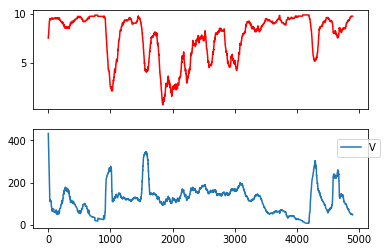

In [5]:
from fxns import running_mean
print(ex.data.keys())
fig, ax = plt.subplots(2,1, sharex=True)
smoothing = 100
ax[0].plot(running_mean(ex.data['total_reward'],smoothing),'r')
#ax[1].plot(running_mean(ex.data['loss'][0], smoothing), label='P')
ax[1].plot(running_mean(ex.data['loss'][1], smoothing), label='V')
ax[1].legend(bbox_to_anchor=(1.05, 0.95))


In [51]:
def plot_trajectory(trajectory):
    
    fig = plt.figure(figsize=(8,8))
    plt.pcolor(ex.env.grid,cmap='bone', vmax=1, vmin=0)
    ax = fig.gca()
    ax.set_aspect('equal')

    ax.add_patch(plt.Rectangle((15,15), width=0.99, height=1, linewidth=1, ec='white', fill=False))
    rows = trajectory[:,0]
    cols = trajectory[:,1]
    ax.add_patch(plt.Rectangle((rows[0],cols[0]), width=0.99, height=1, linewidth=1, ec='red', fill=False))
    dx, dy = [],[]
    for ind in range(len(rows)-1):
        dx.append(rows[ind+1]-rows[ind])
        dy.append(cols[ind+1]-cols[ind])

    dx = np.asarray(dx)*0.25
    dy=np.asarray(dy)*0.25
    for i in range(10):#len(dx)):
        plt.arrow(rows[i]+0.5,cols[i]+0.5, dx[i], dy[i], head_width=0.2, head_length=0.2, color='white',alpha=0.5)

    ax.invert_yaxis()
    plt.show()


(0, 9)


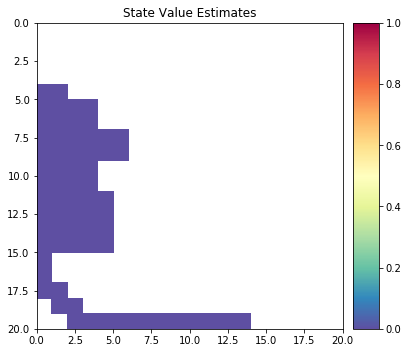

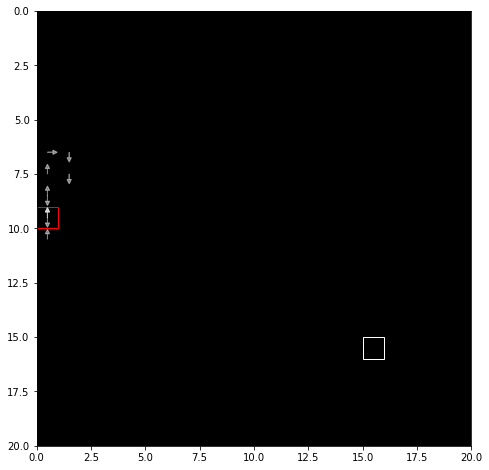

In [71]:

sar = ex.data['sar'][0:200]



for j in range(2):#len(sar)):
    i = j + 4
    if sum(np.vstack(sar[i])[:,3]) <0: 
        print(np.vstack(sar[i])[0,0])
        rpe_data = ex.data['rpe_tracking'][i]
        expt.plot_valmap(ex.env, rpe_data.T)
        trajectory = np.vstack(sar[i])[:,0]
        plot_trajectory(np.vstack(trajectory))




['pillow', 'imagemagick', 'imagemagick_file', 'html']


NameError: name 'ex' is not defined

In [ ]:
policies = ex.data['pol_tracking']
values = ex.data['val_tracking']

In [ ]:
load_data = pickle.load(open(parent_dir + f'results/{run_id}_data.p', 'rb'))
load_data['sar'] = []
t_to_date = load_data['trials_run_to_date']
for key in load_data.keys():
    if key == 'trials_run_to_date':
        load_data[key] += ex.data[key]
    elif len(load_data[key]) == t_to_date:
        load_data[key] += ex.data[key]
    else:
        for i in range(len(load_data[key])):
            load_data[key][i] += ex.data[key][i]

for i in load_data.keys():
    print(type(load_data[i]), i )


In [ ]:
#pickle.dump(load_data, open(f'{parent_dir}results/{run_id}_data.p', 'wb'))

In [ ]:
ex.run(50000, NUM_EVENTS, alpha=alpha, beta=beta)

In [ ]:
expt.data_log(log_file,run_id, experiment_type, ex, load_from=load_id)

In [ ]:
import torch
mem_location = (13,13)
observation = torch.Tensor(np.expand_dims(ex.env.get_observation(agtlocation=mem_location), axis=0))
policy_, value_, phi_, psi_ = ex.agent(observation)
lin_act = tuple(np.round(psi_.data[0].numpy(), 4))

ex.episodic.recall_mem(lin_act, timestep=0)

[]


ValueError: need at least one array to concatenate

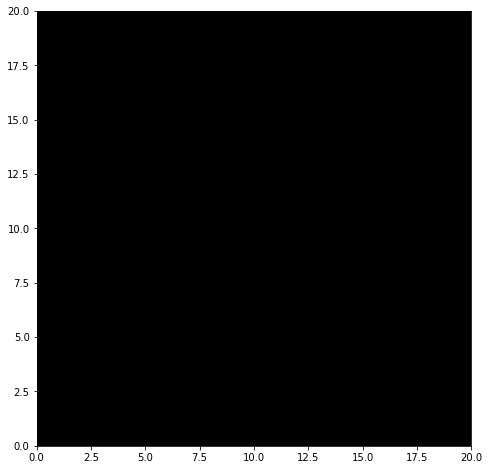

In [17]:
print(ex.data['visited_states'][0:2])



In [ ]:
pols, vals = expt.get_snapshot(env.get_sample_obs(), env, agent)
gp.plot_polmap(env, pols)
gp.plot_valmap(env, vals, v_range=[0,10])

In [ ]:
ex.run(10000,250,reset_data=True)

In [ ]:
from fxns import running_mean
plt.plot(running_mean(ex.data['total_reward'],30))

In [ ]:
#run_id = uuid.uuid4()
#expt.data_log(run_id, experiment_type, ex, load_from=load_id)

In [ ]:
from fxns import running_mean
pen = env.step_penalization
rewards = np.vstack(ex.data['sar'])[:,2]

z_rewards = rewards.copy()
for ind, i in enumerate(z_rewards):
    if i <0:
        z_rewards[ind] = 0.0

cs = []
ex.MF_cs = 0
for i in z_rewards:
    ex.policy_arbitration(i)
    cs.append(ex.MF_cs)
    
plt.figure()
plt.plot(rewards, "r|")
plt.plot(ex.data['confidence_selection'][0], 'b', label='with step penalization')
plt.plot(cs, 'g', label='without step penalization')

plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.title(f'Penalization={pen}, alpha={alpha}, beta={beta}')
#xstart = 6000
#plt.xlim([xstart,xstart+500])
plt.show()
plt.close()

In [ ]:
#### trying some craziness -- delete later (Jul 24)
plt.figure()
x = ex.data['confidence_selection'][0] # MFCS
y = ex.data['confidence_selection'][1] # policy_choice
viridis = cm.get_cmap('inferno', len(x)).colors
plt.scatter(x, y, c = viridis, alpha=0.3, edgecolor='k')
plt.yticks([0,1], ['MF', 'EC'])
plt.ylim([-0.5, 1.5])
plt.xlim([0,1])
plt.show()
plt.close()

plt.figure()
x = ex.data['confidence_selection'][0] # MFCS
y = ex.data['confidence_selection'][1] # policy_choice
viol = [[],[]] #mf ec

for ind, i in enumerate(x):
    viol[y[ind]].append(i)

print(viol)
plt.figure()
plt.violinplot(viol, positions = [0,1], vert=False, showmeans=True)
plt.xlim([0,0.1])
plt.yticks([0,1], [f'MF (n={len(viol[0])})', f'EC (n={len(viol[1])})'])
plt.show()
plt.close()

plt.figure()
y = ex.data['confidence_selection'][0] # MFCS
x = np.arange(len(y))
cols = ['b', 'g'] #mf , ec
z = ex.data['confidence_selection'][1] # policy_choice
col = [cols[i] for i in z]

plt.scatter(x, y, c = col, alpha=0.3)
plt.show()
plt.close()

In [ ]:
from ipywidgets import interactive
%matplotlib inline


def g(x):
    plt.plot(rewards, 'r|')
    plt.plot(ex.data['confidence_selection'][0], 'b')
    plt.plot(cs, 'g')
    plt.xlim(x, x+500)
    plt.show()

interactive_plot = interactive(g, x=(0,len(rewards)-500,500))
interactive_plot

In [ ]:
mpol_array = np.zeros(env.grid.shape, dtype=[(x, 'f8') for x in env.action_list])

for i in mem.cache_list.keys():
    values = mem.cache_list[i]
    row, col = values[2]
    pol = mem.recall_mem(i, timestep=0)
    mpol_array[row, col] = tuple(pol)
    
from environment import plotting
reload(plotting)
plotting.plot_pref_pol(env, mpol_array)



In [ ]:
print(ex.data['confidence_selection'][0])

In [ ]:
a = ['MF', 'EC']
for x,y in zip(np.vstack(ex.data['sar']), ex.data['confidence_selection'][1]):
    print(x, a[y])

In [ ]:
plt.plot(ex.data['total_reward'])

In [ ]:
## example decay curves 
alpha = 0.01
beta = 10000
ex = expt.Experiment(agent, env, alpha = alpha, beta = beta)
# 100 instances 
prob = 0.15
num = 100
pen = -0.01
n_rewards = np.random.choice([pen,1], num, p=[1-prob, prob])
z_rewards = n_rewards.copy()
z_rewards[z_rewards == pen] = 0

n_cs = []
z_cs = []
for i in n_rewards:
    ex.policy_arbitration(i)
    n_cs.append(ex.MF_cs)

for j in z_rewards:
    ex.policy_arbitration(j)
    z_cs.append(ex.MF_cs)

plt.figure()
plt.plot(n_rewards, "r|")
plt.plot(z_rewards, "b|")
plt.plot(n_cs, 'r', label='with penalization in MFCS')
plt.plot(z_cs, 'b', label='no penalization in MFCS')
plt.legend(bbox_to_anchor=(1.05, 0.95))
plt.title(f'Penalization={pen}, alpha={alpha}, beta={beta}')
plt.show()
plt.close()

x = np.subtract(z_cs, n_cs)
plt.figure()
plt.plot(n_rewards, 'k|')
plt.plot(x)
plt.show()
plt.close()

In [ ]:
print(n_rewards, z_rewards)